papers to read

https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewFile/16230/16250

https://www.ncbi.nlm.nih.gov/pubmed/17278461

https://www.jneurosci.org/content/jneuro/33/13/5475.full.pdf

https://www.nature.com/articles/s41598-018-38151-9

https://www.sciencedirect.com/science/article/pii/S0896627311008798?via%3Dihub


In [1]:
# data tools
import numpy as np
import wkw
import tensorflow as tf

# skeleton tools
import kimimaro
# other tools
import time
import re
import scipy.io as sio
import os
import sys
from tqdm import tqdm
from types import SimpleNamespace
from skimage.transform import rescale, resize, downscale_local_mean
import datetime
import numpy as np
import codat.nn.unet
import glob
import matplotlib.pyplot as plt
import cv2 as cv
from scipy.ndimage.measurements import label,find_objects
from scipy import ndimage
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.ndimage.morphology import binary_dilation, generate_binary_structure, iterate_structure
# from scipy.ndimage.morphology import binary_closing, binary_dilation, binary_erosion
# from scipy.ndimage.measurements import label
import time
from wkskel import Skeleton

/afs/ipp/.cs/python_modules/amd64_generic/tensorflow/1.12.0-gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/afs/ipp/.cs/python_modules/amd64_generic/tensorflow/1.12.0-gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/afs/ipp/.cs/python_modules/amd64_generic/tensorflow/1.12.0-gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint

In [2]:
def print_graphs(x,node=(434,1049),name='tab10'):
    fig, ax = plt.subplots(1, len(x), sharex=True, sharey=True,figsize=(8,8))
    for i,val in enumerate(x):
        ax[i].imshow(val.T, cmap=plt.get_cmap(name))
        if node is not None:
            ax[i].scatter(node[0],node[1], s=200, c='red', marker='o')
#         plt.colorbar(z,cax=ax[i])
    plt.show()

In [56]:
skel = Skeleton("../myelin_seg_data/axons_meike/cell_13_v2_axon.nml")
dset = wkw.Dataset.open("/conndata/vkhare/varun_myelin_column/segmentation/1")

In [57]:
x = time.time()
for idx, row in skel.nodes[0].iterrows():
    node = row['position'].values.astype(np.int64)//[2,2,1]
    if np.all(node>=0):
        cube = dset.read(node,[1,1,1])
        if(np.mean(cube)>=1):
            skel.nodes[0].at[idx,'comment'] = "myelinated"
            print("got one")
time.time()-x

65.71427273750305

In [59]:
3

In [54]:
skel.nodes[0][skel.nodes[0]['comment'] == "myelinated"]

id  position                   radius      rotation           inVp  \
                      x         y       z                    x    y    z        
21227  133673  120295.0  165149.0  5593.0    1.5  1.578505e+12  0.0  0.0    0   
24551  133031  119638.0  165808.0  5585.0    1.5  1.578505e+12  0.0  0.0    1   
28780  134025  120269.0  165161.0  5593.0    1.5  1.578505e+12  0.0  0.0    0   
32332  134145  120434.0  165116.0  5592.0    1.5  1.578505e+12  0.0  0.0    0   
33348  133566  120397.0  165123.0  5592.0    1.5  1.578505e+12  0.0  0.0    0   
36142  134644  120737.0  165087.0  5584.0    1.5  1.578505e+12  0.0  0.0    1   
37018  134053  120371.0  165127.0  5593.0    1.5  1.578505e+12  0.0  0.0    0   
37801  134517  120184.0  165200.0  5598.0    1.5  1.578505e+12  0.0  0.0    0   
37810  134295  119580.0  165828.0  5584.0    1.5  1.578505e+12  0.0  0.0    1   
41650  133396  120231.0  165173.0  5595.0    1.5  1.578505e+12  0.0  0.0    0   

      inMag bitDepth interpolation time     comment  
                                                     
21227     0        0          True    0  myelinated  
24551     0        0          True    0  myelinated  
28780     0        0          True    0  myelinated  
32332     0        0          True    0  myelinated  
33348     0        0          True    0  myelinated  
36142     0        0          True    0  myelinated  
37018     0        0          True    0  myelinated  
37801     0        0          True    0  myelinated  
37810     0        0          True    0  myelinated  
41650     0        0          True    0  myelinated

In [55]:
dset.read([120295.0,165149.0,5593.0],[1,1,1])

array([[[[2]]]], dtype=uint8)

In [3]:
mm_axon_dir = '/u/martinsc/data/mergermode_annotations/mSEM/2018-11-13_scMS109_1st2900_v01/axons/MS_scMS109_groundTruth_axons_mergerMode_09_05_2019/'
segIds_matfilename = 'mSEM_axons_mergerMode_segIds_v3.2.mat'
mat_out_filename = 'mSEM_axons_mergerMode_kimimaro_skeletons_from_segIds_v3.2_fullrun.mat'

In [4]:
RAW_DATA_PATH = "/tmpscratch/webknossos/Connectomics_Department/2018-11-13_scMS109_1st2900_v01_segmentation_500mu_mag2/color/1/"
TARGET_DATA_PATH = "/tmpscratch/webknossos/Connectomics_Department/2018-11-13_scMS109_1st2900_v01_segmentation_500mu_mag2_varun_myelin/segmentation/1/"
SEG_PATH='/tmpscratch/webknossos/Connectomics_Department/2018-11-13_scMS109_1st2900_v01_segmentation_500mu_mag2/segmentation/1/'
big_cube_Size = np.array([624,624,142])
nodes = sio.loadmat('../myelin_seg_data/train.mat')
cubes_in = nodes['final'].T
raw_data = wkw.Dataset.open(RAW_DATA_PATH)
target_annotations = wkw.Dataset.open(TARGET_DATA_PATH)
bbox = np.array([69777, 86000, 1100, 2900, 3312, 572])
coors = bbox[:3]
big_cube_Size = bbox[3:6]

In [5]:
matfilecontent = sio.loadmat('/u/martinsc/data/mergermode_annotations/mSEM/2018-11-13_scMS109_1st2900_v01/axons/MS_scMS109_groundTruth_axons_mergerMode_09_05_2019/kimimaro_skels_v3.2/tdef_mSEM_axons_mergerMode_kimimaro_skeletons_from_segIds_v3.2_fullrun.mat', squeeze_me=True)

for key, _ in matfilecontent.items():
    if key[0:2] != '__':
        print('\t%s' % key)
mat = SimpleNamespace(**matfilecontent)

	dset_params
	task_params
	tasks
	tracings
	gt_tracings


In [6]:
segs = wkw.Dataset.open(SEG_PATH)
segs = segs.read(coors,big_cube_Size)[0]
cubes = np.copy(segs)

In [7]:
annotations = wkw.Dataset.open(TARGET_DATA_PATH)
tc = annotations.read(coors,big_cube_Size)[0]

In [8]:
tasks = {1:[3],3:[246,269,440,536],4:[387],6:[637,638,639,640,641,642,643,644,647,649],9:[964,975],10:[1135,1136]}

In [13]:
def test_myelination(mln_pred,axn_seg,x,x2,grid,size):
    a = (x2-x)/np.sqrt(np.sum((x2-x)**2))
    M = np.cross(a,np.cross(a,grid))
    v = np.rint(x-M).astype(np.int32).reshape(-1,3)
    v = v[(np.prod(v>0,axis=-1).astype(np.bool)),:] #filter negatives
    v = v[(v[:,0]<size[0]) & (v[:,1]<size[1]) & (v[:,2]<size[2])] #filter overflow
    intrsct = (mln_pred == 2) & axn_seg
    return np.sum(intrsct[v[:,0],v[:,1],v[:,2]])/np.sum(axn_seg[v[:,0],v[:,1],v[:,2]])


N = 70# anglebins
theta, phi = np.linspace(2*np.pi/N, 2*np.pi, num=N), np.linspace(2*np.pi/N, 2*np.pi, num=N),
r = np.linspace(1,200, num=200)
grid = np.stack([(np.cos(theta)[:,None]*np.cos(phi)[None,:])[None,:,:]*r[:,None,None],
                (np.sin(theta)[:,None]*np.cos(phi)[None,:][None,:,:]*r[:,None,None]),
                np.repeat(np.sin(phi)[None,:],N,axis=0)[None,:,:]*r[:,None,None]],axis=-1)
for axn_idx,task_list in tasks.items():
    axn_seg_mask = np.isin(segs,mat.gt_tracings['segIdsGrouped'].item()[axn_idx-1])
    for task in task_list:
        axon = mat.gt_tracings['r'].item()[task]
        for i in range(len(axon)-1):
            x2 = axon[i+1]-1 -coors
            x = axon[i]-1-coors
            if np.any(x>big_cube_Size):
                continue
            fraction = test_myelination(tc,axn_seg_mask,x,x2,grid,big_cube_Size)
            print("myelination fraction is {0:.4f}".format(fraction))

In [15]:
from collections import defaultdict
import shutil
mappings = sio.loadmat('../myelin_seg_data/volume_mappings2.mat')
k = sio.loadmat('../myelin_seg_data/annotations.mat')
dir_ = '/tmpscratch/webknossos/Connectomics_Department/2018-11-13_scMS109_1to7199_v01_mag2_varun_myelin_training_annotations/segmentation/1/' 
seg = wkw.Dataset.open('/tmpscratch/webknossos/Connectomics_Department/2018-11-13_scMS109_1to7199_v01_l4_06_24_fixed_mag2/segmentation/1/')

inside_nodes = {}
bbox = {}
valid_cubes = []
for j,i in enumerate(k['k']['names'][0][0]):
    if 'axon' in i[0][0]:
        inside_nodes[int(i[0][0].split()[1])]=k['k']['nodes'][0][0][j][0]
    else:
#         print(i[0][0].split()[1])
        bbox[int(i[0][0].split()[1])]=k['k']['nodes'][0][0][j][0]
    if '#d' in i[0][0]:
        valid_cubes.append(int(i[0][0].split()[1]))
valid_cubes.reverse()

shutil.rmtree(dir_,ignore_errors=True)
dataset = wkw.Dataset.create(dir_,  wkw.Header(np.uint8))
map_dict = defaultdict(set)
for idx,i in enumerate(valid_cubes):
    nd = mappings['k'][0][0]['nodes'][idx][0]-1
    coords = np.min(bbox[i],axis=0)[:3].astype(np.int64)-1
    mi = np.min(nd,axis=0)[:3]
    mi = np.min([coords,mi],axis=0)
    diff = (np.max(nd,axis=0)[:3]-mi)+1
    off = coords-mi
    sizes = np.max([diff,np.array([624,624,142])+off],axis=0)
    seg_mask = seg.read(mi,sizes)[0]
    target = target_annotations.read(coords,np.array([624,624,142]))[0]
    for node in nd:
        t = node[:3]-mi
        if seg_mask[t[0],t[1],t[2]]!=0:
            map_dict[i].add(seg_mask[t[0],t[1],t[2]])
    final = np.zeros(target.shape).astype(np.int64)
    final[np.isin(seg_mask[off[0]:off[0]+624,off[1]:off[1]+624,off[2]:off[2]+142], list(map_dict[i]))] = 2
    final[target == 1] = 1
    dataset.write(coords, np.expand_dims(final,0).astype(np.uint8))
    

In [75]:
for j,i in enumerate(k['k']['names'][0][0]):
    if 'axon' in i[0][0]:
        inside_nodes[int(i[0][0].split()[1])]=k['k']['nodes'][0][0][j][0]
    else:
#         print(i[0][0].split()[1])
        bbox[int(i[0][0].split()[1])]=k['k']['nodes'][0][0][j][0]
    if '#d' in i[0][0]:
        valid_cubes.append(int(i[0][0].split()[1]))
valid_cubes

[2, 3, 5, 6, 8, 9, 12, 13, 14, 83]

In [7]:
from collections import defaultdict
import shutil
mappings = sio.loadmat('../myelin_seg_data/volume_mappings.mat')
k = sio.loadmat('../myelin_seg_data/annotations.mat')
dir_ = '/tmpscratch/webknossos/Connectomics_Department/2018-11-13_scMS109_1to7199_v01_mag2_varun_myelin_training_annotations/segmentation/1/' 
seg = wkw.Dataset.open('/tmpscratch/webknossos/Connectomics_Department/2018-11-13_scMS109_1to7199_v01_l4_06_24_fixed_mag2/segmentation/1/')

inside_nodes = {}
bbox = {}
valid_cubes = []
for j,i in enumerate(k['k']['names'][0][0]):
    if 'axon' in i[0][0]:
        inside_nodes[int(i[0][0].split()[1])]=k['k']['anno_tree'][0][0][j][0]
    else:
#         print(i[0][0].split()[1])
        bbox[int(i[0][0].split()[1])]=k['k']['anno_tree'][0][0][j][0]
    if '#d' in i[0][0]:
        valid_cubes.append(int(i[0][0].split()[1]))
valid_cubes.reverse()


In [26]:
'''
This script generates a distance transform segmentation mask from
cell masks so that they can be preloaded directly
'''
dir_ = '../myelin_seg_data/seg_dst_mask'
shutil.rmtree(dir_,ignore_errors=True)
dataset = wkw.Dataset.create(dir_,  wkw.Header(np.uint8))
all_cubes =[1,2,6,7,8,9,10,11,12,13]+[3,4,16,5]
for idx,i in enumerate(all_cubes):
    coords = np.min(bbox[i],axis=0)[:3].astype(np.int64)
    seg_mask = seg.read(coords,[624,624,142])[0]
    segs = cv.Laplacian(np.float32(seg_mask),cv.CV_32F)
    segs[np.abs(segs)>0] = 1
    segs[np.abs(segs)==0] = 0
    segs = ndimage.distance_transform_edt(1-segs)
    segs = segs/segs.max()*255
    dataset.write(coords, np.expand_dims(segs,0).astype(np.uint8))

In [35]:

coords = np.min(bbox[2],axis=0)[:3].astype(np.int64)
target = target_annotations.read(coords,np.array([624,624,142]))[0]
anno_read = wkw.Dataset.open(dir_)
final = anno_read.read(coords,np.array([624,624,142]))[0]
a = np.zeros((3,3,3))
a[:,:,1] = 1
test,_ = label(1-target,a)
# for i in range(b.shape[2]):
#     print(i,np.unique(b[:,:,i]).shape,np.unique(test[:,:,i]).shape)

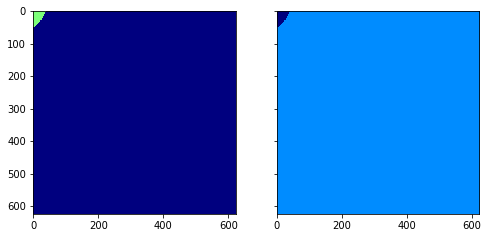

In [36]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(8,8))

im = ax[0].imshow(final[...,0].T, cmap=plt.get_cmap('jet'), animated=True)
test_im = ax[1].imshow(test[...,0].T, cmap=plt.get_cmap('jet'), animated=True)

# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(final[...,j].T)
    test_im.set_array(test[...,j].T)
    return [im,test_im]

# kick off the animation
ani = animation.FuncAnimation(fig, updatefig, frames=range(final.shape[2]), 
                              interval=200, blit=True,cache_frame_data=False)
#rc('animation', html='html5')
HTML(ani.to_html5_video())